# Analyse de sentiments

C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from os import getcwd
import matplotlib.image as mpimg


In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
file_path

'c:\\Users\\User\\WORK\\workspace-ia\\simplon\\2022-02-NLP-Sentiments-analyses\\'

## Les données

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). 

Il y a trois fichiers textes à importer et à concaténer pour former un dataset avec deux colonnes:
- Une "texte" comportant le contenu du commentaire
- Une "sentiment" comportant une note de 0 ou 1

In [3]:
print("Chargement des données...")
file_name_amazon_label = "amazon_cells_labelled.txt"
file_name_imdb_labelled = "imdb_labelled.txt"
file_name_yelp_labelled = 'yelp_labelled.txt'

df_origin_amazon_label = pd.read_csv(file_path+"\\data\\"+file_name_amazon_label, sep='\t', header=None)
df_origin_imdb_labelled = pd.read_csv(file_path+"\\data\\"+file_name_imdb_labelled, sep='\t', header=None)
df_origin_yelp_labelled= pd.read_csv(file_path+"\\data\\"+file_name_yelp_labelled, sep='\t', header=None)

print("Chargement des données", df_origin_amazon_label.shape, df_origin_imdb_labelled.shape,  df_origin_yelp_labelled.shape, ".......................................... END")

Chargement des données...
Chargement des données (1000, 2) (748, 2) (1000, 2) .......................................... END


In [4]:
df_origin_amazon_label.head()

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [5]:
df_origin_amazon_label["website"] = "amazon"
df_origin_imdb_labelled["website"] = "imdb"
df_origin_yelp_labelled["website"] = "yelp"

In [6]:
df_origin_full = df_origin_amazon_label.append(df_origin_imdb_labelled)
df_origin_full = df_origin_full.append(df_origin_yelp_labelled)
print(df_origin_full.shape)
df_origin_full.head()

(2748, 3)


C:\Users\User\AppData\Local\Temp\ipykernel_56012\1929029598.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_origin_full = df_origin_amazon_label.append(df_origin_imdb_labelled)
C:\Users\User\AppData\Local\Temp\ipykernel_56012\1929029598.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_origin_full = df_origin_full.append(df_origin_yelp_labelled)


,0,1,website
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon


In [7]:
df_origin_full = df_origin_full.rename(columns={0: "sentence", 1: "connotation"})
df_origin_full.columns

Index(['sentence', 'connotation', 'website'], dtype='object')

#### Questions préalables: 
- Quelle est la taille du dataset ?
- Comment est distribuée la variable sentiment ?


In [8]:
df_origin_full.shape

(2748, 3)

In [10]:
df_origin_full["connotation"].value_counts()

1    1386
0    1362
Name: connotation, dtype: int64

In [16]:
df_origin_full.columns

Index(['sentence', 'connotation', 'website'], dtype='object')

In [25]:
df_origin_full["connotation_label"] = np.nan
df_origin_full.loc[df_origin_full['connotation'] == 0, 'connotation_label'] = "negativ"
df_origin_full.loc[df_origin_full['connotation'] == 1, 'connotation_label'] = "positiv"
df_origin_full

,sentence,connotation,website,connotation_label
0,So there is no way for me to plug it in here i...,0,amazon,negativ
1,"Good case, Excellent value.",1,amazon,positiv
2,Great for the jawbone.,1,amazon,positiv
3,Tied to charger for conversations lasting more...,0,amazon,negativ
4,The mic is great.,1,amazon,positiv
...,...,...,...,...
995,I think food should have flavor and texture an...,0,yelp,negativ
996,Appetite instantly gone.,0,yelp,negativ
997,Overall I was not impressed and would not go b...,0,yelp,negativ
998,"The whole experience was underwhelming, and I ...",0,yelp,negativ


In [27]:
df_group = df_origin_full.groupby(["website", "connotation_label"], as_index=True)['connotation'].count()
df_group

website  connotation_label
amazon   negativ              500
         positiv              500
imdb     negativ              362
         positiv              386
yelp     negativ              500
         positiv              500
Name: connotation, dtype: int64

In [28]:
df_group_ri = df_group.reset_index()
df_group_ri

,website,connotation_label,connotation
0,amazon,negativ,500
1,amazon,positiv,500
2,imdb,negativ,362
3,imdb,positiv,386
4,yelp,negativ,500
5,yelp,positiv,500


In [21]:
pd.crosstab(df_group_ri["website"], columns, values=None, rownames=None, colnames=None, aggfunc=None, margins=False, margins_name='All', dropna=True, normalize=False)

website           amazon      imdb      yelp     
connotation            0    1    0    1    0    1
connotation count    500  500  362  386  500  500

<AxesSubplot:>

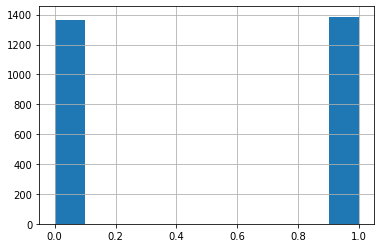

In [15]:
df_origin_full.connotation.hist()

#### Question 1: Combien y a t'il de mots dans l'ensemble du corpus ? Sont-ils "homogènes" ? 


### Import du module permettant le traitement de texte: nltk

#### Consigne 1: Récupérer le corpus de mots sans la ponctuation ni les stopwords

#### Question 2: Combien de mots restent-ils ? 

## Exercice 1 : approche td-idf

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*.

#### Consigne 2: Utiliser OneHotEncoder ou CountVectorizer pour représenter les données sous forme d'une matrice contenant autant de colonnes que de mots dans le corpus

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

#### Consigne 3: lancer un modèle de classification pour prédire les sentiments de 30% des observations



*   Séparer échantillon train / test
*   Entrainer un modèle de classification
*   Afficher la matrice de confusion
*   Calculer l'accuracy, la précision et le recall
*   Votre modèle est-il soumis à un overfitting ?

#### Consigne 4: Utiliser TF-IDF pour représenter les données et relancer un modèle de classification

## Exercice 2 : word2vec

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity).

#### Consigne 5: Utiliser Word2vec pour représenter les données et relancer un modèle de classification

## Exercice 3 : Comparer les deux approches

#### Consigne 6: Faire un graphique montrant les courbes ROC associées au deux modèles

#### Consigne 7: Faire un graphique montrant les courbes Precision-Recall associées aux deux modèles

### BONUS: reprendre l'étape de One_hot_encoding et ajouter une étape de réduction de dimension (type ACP)

In [ ]:
import nltk
import os
from tools import ap

def format_sentence(sent):
    return ({ word: True for word in nltk.word_tokenize(sent.decode('utf-8')) })


def load_training_set():
    training = []

    for fp in os.listdir(ap('aclImdb/train/pos')):
        example = '{}/{}'.format(ap('aclImdb/train/pos'), fp)
        with open(example) as fp:
            for i in fp:
                training.append([format_sentence(i), 'pos'])

    for fp in os.listdir(ap('aclImdb/train/neg')):
        example = '{}/{}'.format(ap('aclImdb/train/neg'), fp)
        with open(example) as fp:
            for i in fp:
                training.append([format_sentence(i), 'neg'])

    return training

training = load_training_set()

In [ ]:
training[:3]

In [ ]:
from nltk.classify import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(training)

In [ ]:
classifier.show_most_informative_features(n=25)